https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

https://www.kaggle.com/code/saurabhprajapat/conversational-chatbot-using-encoder-and-decoder

In [65]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
from sklearn.model_selection import train_test_split
from keras.layers import TextVectorization
import numpy as np
import tensorflow as tf
import keras
import random
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Add, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import activations, preprocessing , utils
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters, RandomSearch
import nltk
from nltk.translate.bleu_score import sentence_bleu

env: TF_FORCE_GPU_ALLOW_GROWTH=true


# Corpus

In [2]:
# chargement des données
def load_shuffle_data(path="../data/wikianswers-paraphrases-1.0/word_alignments.txt"):
    random.seed(42)
    count = 0
    all_sents = []
    with open(path) as file:
        for line in file:
            s, c, _ = line.strip().split("\t")
            if s != c and count < 10000:
                all_sents.append((s, c))
                count+=1
        # mélange des données 
        random.shuffle(all_sents)
    return all_sents

In [3]:
all_sents = load_shuffle_data()

In [4]:
input_lines = [text for text, _ in all_sents]
target_texts = [paraph for _, paraph in all_sents]

In [91]:
input_lines[10:30]

['. and all the symptom of lupus ?',
 '.1 decagram equal how many ?',
 '0.5 litre pint ?',
 '.5 mile equal how many kilometer ?',
 '------- be the largest all sand desert in the world ?',
 '0.18642 mile equal foot ?',
 '.25 mg equal how many international units ?',
 '.166 of a ounce equal how many milligram ?',
 '.005 ml convert to liter ?',
 '.09 horsepower equal how many watt ?',
 "'' what do joe jonas like in a girl '' ?",
 '0.4 as a fraction be 25 ?',
 '.25 acre be how many square foot ?',
 '- the year that the cellular be invent ?',
 '0.5 unit of glucagon iv ?',
 '.5 ml be equal to dram ?',
 "'' who invent the pulley '' ?",
 '0.18642 mile equal how many accurate ?',
 "'' chemical formulum for magnesium sulphate '' ?",
 '0.4 as a fraction ?']

In [6]:
target_texts[:10]

['who invent the first american typewriter ?',
 'should you buy a evo or a stus ?',
 'how many meter equal a ceamerter ?',
 'what be importance of measurement in everyday life ?',
 'how much be george pullman worth ?',
 'a word sufix for hepta ?',
 'how many milogram be in one milliliter ?',
 'mexican american be end ?',
 'what can lift weight help with ?',
 'how many foot be in a qourder mile ?']

In [7]:
# nombre de phrases sources
len(set(input_lines)), len(set(target_texts))

(577, 8279)

# Préparation des données

## Vectorisation des données

In [8]:
MAX_LENGTH = 30

In [9]:
vectorizer = TextVectorization(
    split="whitespace",
    standardize=None,
    output_mode="int",
    output_sequence_length=MAX_LENGTH)

In [10]:
output_lines = []
for line in target_texts:
    output_lines.append('<START> ' + line + ' <END>')  

In [11]:
all_texts = input_lines + output_lines
vectorizer.adapt(all_texts)

2023-05-17 21:34:18.670555: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
# tokens uniques du corpus
vectorizer.vocabulary_size()

4746

In [13]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 '?',
 '<START>',
 '<END>',
 'how',
 'be',
 'many',
 'equal',
 'what',
 'in',
 'of',
 'the',
 'a',
 'to',
 "''",
 'do',
 '-',
 'liter',
 'cup']

In [14]:
# word_dict contient les correspondances entre les mots et les entiers
word_dict = dict(zip(vectorizer.get_vocabulary(), range(vectorizer.vocabulary_size())))
# nb de tokens uniques dans le voc
# +1 pour UNK (les OOV)
num_tokens = len(word_dict)+1
print(f'Number of tokens = {num_tokens}')

Number of tokens = 4747


In [15]:
tokenized_input_lines = vectorizer(input_lines)

In [16]:
print(tokenized_input_lines)

tf.Tensor(
[[ 47  48  63 ...   0   0   0]
 [103  17 438 ...   0   0   0]
 [ 91  33   6 ...   0   0   0]
 ...
 [113  20   6 ...   0   0   0]
 [ 15 426 416 ...   0   0   0]
 [ 17   5   7 ...   0   0   0]], shape=(10000, 30), dtype=int64)


In [17]:
tokenized_output_lines = vectorizer(output_lines)

In [18]:
print(tokenized_output_lines)

tf.Tensor(
[[  3  48  63 ...   0   0   0]
 [  3 829  24 ...   0   0   0]
 [  3   5   7 ...   0   0   0]
 ...
 [  3  26  22 ...   0   0   0]
 [  3   9   6 ...   0   0   0]
 [  3   5   7 ...   0   0   0]], shape=(10000, 30), dtype=int64)


## Préparation des données d'entrée pour l'encodeur

In [19]:
encoder_input_data = np.array(tokenized_input_lines)
print(f'Encoder input data shape -> {encoder_input_data.shape}')

Encoder input data shape -> (10000, 30)


In [20]:
encoder_input_data

array([[ 47,  48,  63, ...,   0,   0,   0],
       [103,  17, 438, ...,   0,   0,   0],
       [ 91,  33,   6, ...,   0,   0,   0],
       ...,
       [113,  20,   6, ...,   0,   0,   0],
       [ 15, 426, 416, ...,   0,   0,   0],
       [ 17,   5,   7, ...,   0,   0,   0]])

## Préparation des données d'entrée pour le décodeur

In [21]:
decoder_input_data = np.array(tokenized_output_lines)
print(f'Decoder input data shape -> {decoder_input_data.shape}')

Decoder input data shape -> (10000, 30)


In [22]:
decoder_input_data

array([[  3,  48,  63, ...,   0,   0,   0],
       [  3, 829,  24, ...,   0,   0,   0],
       [  3,   5,   7, ...,   0,   0,   0],
       ...,
       [  3,  26,  22, ...,   0,   0,   0],
       [  3,   9,   6, ...,   0,   0,   0],
       [  3,   5,   7, ...,   0,   0,   0]])

## Préparation des données cibles pour le décodeur

In [23]:
# copie des séquences de sortie tokenized_output_lines
# où le 1er token <START> = supprimé
decoder_target_data = []
for token_seq in tokenized_output_lines:
    decoder_target_data.append(token_seq[1:]) 

# padding='post' permet de remplir par des 0 en fin de séquence
# ajout donc d'un 0 en fin de matrice pour remplacer la suppression du start
padded_output_lines = preprocessing.sequence.pad_sequences(decoder_target_data, maxlen=MAX_LENGTH, padding='post')
# données cibles = convertis en one hot 
onehot_output_lines = utils.to_categorical(padded_output_lines, num_tokens)
decoder_target_data = np.array(onehot_output_lines)
print(f'Decoder target data shape -> {decoder_target_data.shape}')

Decoder target data shape -> (10000, 30, 4747)


# Modèle

In [24]:
def build_model(emb_size=256, learning_rate=0.01, dropout=0.2, optimizer='adam'):
    # modèle seq2seq avec une architecture encodeur/décodeur
    # entrées = données sous la forme de 2 tenseurs (encoder_inputs et decoder_inputs)
    
    # Encodeur
    encoder_inputs = Input(shape=(None,), name="encoder_inputs")
    encoder_embedding = Embedding(num_tokens, emb_size, mask_zero=True, name="encoder_embedding")(encoder_inputs)
    encoder_outputs_1, state_h_1, state_c_1 = LSTM(emb_size, return_sequences=True, return_state=True, dropout=dropout, name="encoder_lstm_1")(encoder_embedding)
    encoder_outputs_2, state_h_2, state_c_2 = LSTM(emb_size, return_sequences=True, return_state=True, dropout=dropout, name="encoder_lstm_2")(encoder_outputs_1)
    # Connexion des couches LSTM en utilisant des connexions résiduelles
    encoder_outputs_2 = Add()([encoder_outputs_1, encoder_outputs_2])
    encoder_outputs_3, state_h_3, state_c_3 = LSTM(emb_size, return_sequences=True, return_state=True, dropout=dropout, name="encoder_lstm_3")(encoder_outputs_2)
    # renvoie : sortie des celllules LSTM + état final des cellules LSTM
    encoder_states = [state_h_3, state_c_3]

    # Décodeur
    # état final des cellules LSTM = utilisée comme entrée pour le décodeur
    decoder_inputs = Input(shape=(None,), name="decoder_inputs")
    decoder_embedding = Embedding(num_tokens, emb_size, mask_zero=True, name="decoder_embedding")(decoder_inputs)
    
    # LSTM du décodeur = configuré pour renvoyer des sorties pour chaque étape de temps
    # ce qui permet de produire des prédictions pour chaque token de sortie
    decoder_outputs_1, _, _ = LSTM(emb_size, return_sequences=True, return_state=True, dropout=dropout, name="decoder_lstm_1")(decoder_embedding, initial_state=encoder_states)
    decoder_outputs_2, _, _ = LSTM(emb_size, return_sequences=True, return_state=True, dropout=dropout, name="decoder_lstm_2")(decoder_outputs_1, initial_state=encoder_states)
    decoder_outputs_2 = Add()([decoder_outputs_1, decoder_outputs_2])
    
    # sortie de cette couche = prédiction finale du modèle
    output = Dense(num_tokens, activation="softmax", name="decoder_dense")(decoder_outputs_2)
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    
    model = Model([encoder_inputs, decoder_inputs], output)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [25]:
def hypermodel(hp: HyperParameters)-> keras.Model:
    lr=hp.Float("learning_rate", min_value=0.001,
                  max_value=0.2,
                  sampling='log')
    
    emb_size = hp.Choice("embedding_size", [128, 256, 512])
 
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, 
                            max_value=0.6, 
                            step=0.1)
    
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    return build_model(emb_size=emb_size, learning_rate=lr, dropout=dropout_rate, optimizer=optimizer)

In [26]:
# recherche du meilleur modèle avec les meilleurs hp
# Cherche les valeurs optimales des hyperparamètres lr, emb_size, dropout, optimizer
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner',
    project_name='emb_lr_dropout_optimizer2')

In [27]:
# définition des paramètres de recherche
tuner.search_space_summary()

Search space summary
Default search space size: 4
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.2, 'step': None, 'sampling': 'log'}
embedding_size (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}


In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [29]:
# train du modèle sur les données d'entrée et de sortie encodées et les cibles décodées
# recherche des meilleurs hp
tuner.search(x=[encoder_input_data, decoder_input_data], y=decoder_target_data, epochs=10, batch_size=124, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Trial 5 Complete [00h 29m 39s]
val_accuracy: 0.5358161926269531

Best val_accuracy So Far: 0.613805890083313
Total elapsed time: 01h 04m 55s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Les meilleurs paramètres sont : {best_hp.values}')

Les meilleurs paramètres sont : {'learning_rate': 0.010831623299388079, 'embedding_size': 128, 'dropout_rate': 0.1, 'optimizer': 'adam'}


In [31]:
# recherche du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, None, 128)    607616      ['encoder_inputs[0][0]']         
                                                                                                  
 encoder_lstm_1 (LSTM)          [(None, None, 128),  131584      ['encoder_embedding[0][0]']      
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

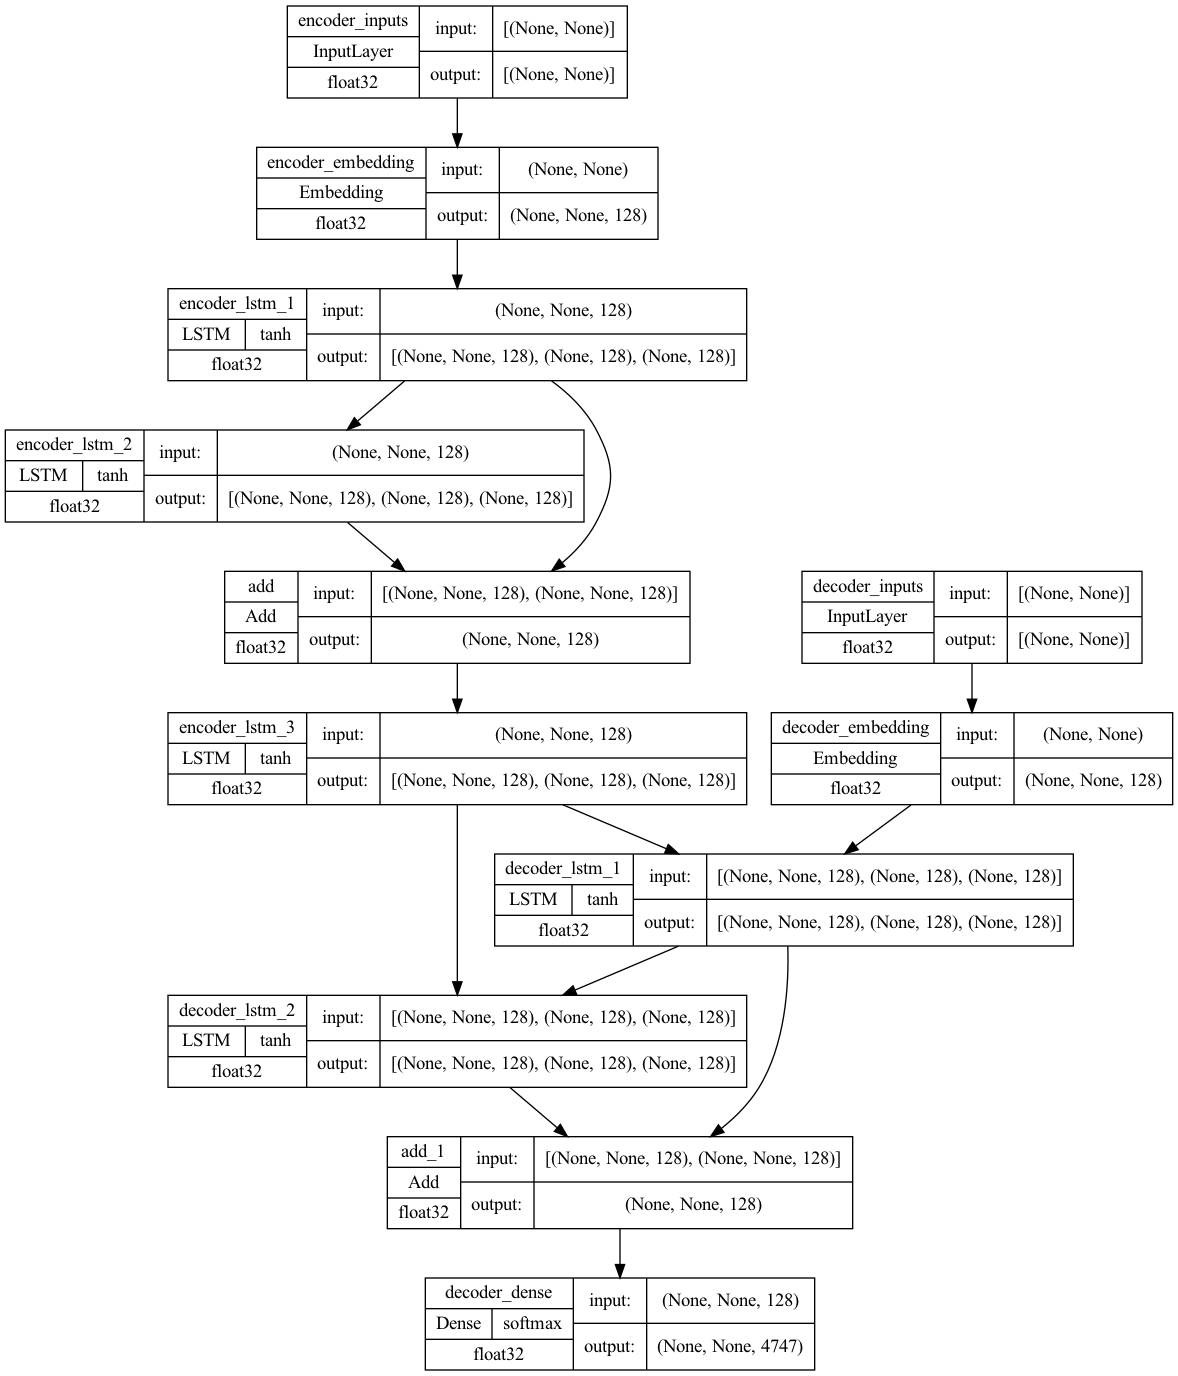

In [32]:
best_model.summary()
keras.utils.plot_model(best_model, "./architecture.png", show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [33]:
# enregistrement du meilleur modèle
best_model.save('model.h5')

In [52]:
model = keras.models.load_model('model.h5')

# Génération de paraphrases

In [57]:
def make_inference_models(model):
    """
    créée 2 modèles qui seront utilisés pdt la phase d'inférence ou de prédiction
    """
    # 1er modèle : prend en entrée les séquences d'entrée et retourne
    # les états cachés générés par l'encodeur LSTM
    encoder_inputs = model.get_layer('encoder_inputs').input
    encoder_embedding = model.get_layer('encoder_embedding')(encoder_inputs)
    encoder_outputs_1, state_h_1, state_c_1 = model.get_layer('encoder_lstm_1')(encoder_embedding)
    encoder_outputs_2, state_h_2, state_c_2 = model.get_layer('encoder_lstm_2')(encoder_outputs_1)
    encoder_outputs_2 = model.get_layer('add')([encoder_outputs_1, encoder_outputs_2])
    encoder_outputs_3, state_h_3, state_c_3 = model.get_layer('encoder_lstm_3')(encoder_outputs_2)
    encoder_states = [state_h_3, state_c_3]
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    # 2eme modèle : prend en entrée les séquences d'entrée et les états cachés retournés par le 1er modèle 
    # et retourne les séquences de sortie / la séquence de mots prédite + les états cachés générés par le décodeur
    decoder_inputs = model.get_layer('decoder_inputs').input
    decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
    decoder_state_input_h = Input(shape=(None,), name="decoder_state_input_h")
    decoder_state_input_c = Input(shape=(None,), name="decoder_state_input_c")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs_1, state_h_1, state_c_1 = model.get_layer('decoder_lstm_1')(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_outputs_2, state_h_2, state_c_2 = model.get_layer('decoder_lstm_2')(decoder_outputs_1, initial_state=decoder_states_inputs)
    decoder_outputs_2 = model.get_layer('add_1')([decoder_outputs_1, decoder_outputs_2])
    decoder_states = [state_h_2, state_c_2]
    output = model.get_layer('decoder_dense')(decoder_outputs_2)
    
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, 
        [output] + decoder_states)

    return encoder_model, decoder_model


In [58]:
def str_to_tokens(sentence : str):
    """ 
        prend une chaine de caractères en entrée 
        et la transforme en une séquence de tokens
        qui peuvent être utilisés en entrée pour le modèle
    """
    words = sentence.lower().split()
    tokens_list = []
    for word in words:
        # récupère l'entier correspondant dans le dictionnaire word_dict
        tokens_list.append(word_dict[word])
    # renvoie la séquence de tokens obtenue en appliquant un padding pour avoir la longueur max
    return preprocessing.sequence.pad_sequences([tokens_list], maxlen=MAX_LENGTH, padding='post')

In [93]:
enc_model, dec_model = make_inference_models(model)

# génération des paraphrases en utilisant le modèle entrainé
# utilise les 2 modèles d'inférence enc_model et dec_model créés à partir du modèle
# entrainé pour encoder et décoder une phrase

print("Pour quitter, entrer 'q'")

for epoch in range(encoder_input_data.shape[0]):
    # encode la phrase d'origine avec enc_model
    user_input = input("User: ")
    
    if user_input.lower() == 'q':
        break
    
    states_values = enc_model.predict(str_to_tokens(user_input))
    # génère un vecteur vide pour la séquence cible
    empty_target_seq = np.zeros((1, 1))
    # initialise la séquence cible avec le token "start"
    empty_target_seq[0, 0] = word_dict['<START>']
    
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        # le décodeur dec_model = utilisé pour prédire le prochain mot de la séquence cible
        # en fonction des mots précédemment générés et des vecteurs d'état en cours (màj à chaque predict)
        dec_outputs, h, c = dec_model.predict([empty_target_seq ] + states_values)
        # indice du mot échantillonné = obtenu en sélectionnant le mot avec la probabilité la plus élevée 
        # parmi les sorties prédites du décodeur 
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in word_dict.items() :
            if sampled_word_index == index :
                # mot prédit = ajouté à la séquence cible
                decoded_translation += f' {word}'
                sampled_word = word
                
        # condition d'arrêt : le modèle prédit le mot "end" ou la séquence cible atteint sa longueur max
        if sampled_word == '<END>' or len(decoded_translation.split()) > MAX_LENGTH :
            stop_condition = True
            
        # màj de la séquence cible
        empty_target_seq = np.zeros((1, 1))  
        empty_target_seq[0, 0] = sampled_word_index
        
        # màj des états 
        states_values = [h, c] 
        
    print("Paraphrase:" + decoded_translation.replace(' <END>', ''))
    print()

    # Calcul du score BLEU
    reference_tokens = [user_input.split()]
    generated_tokens = decoded_translation.replace(' <END>', '').split()
    bleu_score = sentence_bleu(reference_tokens, generated_tokens)
    print("BLEU score:", bleu_score)
    print()

## Phrases test :
# phrases avec un score bleu = 0
# ' 5 '10 inch in cm 
# endeavour ' be the four wheeler launch by
# canada 's tallest mountain 

# phrases avec un score bleu > 1 -> inhabituel
# a young lizard
# lizard in canada ? 
# where are you ?
# what do the ' netted sunbeam ' meanhow do it dance 
# 0.16 milligram be equal to how many milliliter ?

# what is your favorite color ? -> erreur : "is" et "your"

Pour quitter, entrer 'q'


User:  0.16 milligram be equal to how many milliliter ?


1/1 [==============================] - 0s 14ms/step
Paraphrase: how many gram be one mg can ?

BLEU score: 6.805395922591311e-155



User:  where are you ?


1/1 [==============================] - 0s 14ms/step
Paraphrase: what be project to make what be project ?

BLEU score: 1.0518351895246305e-231



User:  lizard in canada ?


1/1 [==============================] - 0s 13ms/step
Paraphrase: how many tablespoon be equal to 4 homny spoon ?

BLEU score: 1.0244914152188952e-231



User:  what do the ' netted sunbeam ' meanhow do it dance 


1/1 [==============================] - 0s 15ms/step
Paraphrase: what be what be the dow magnet ?

BLEU score: 8.853864984883467e-232



User:  ' 5 '10 inch in cm


1/1 [==============================] - 0s 14ms/step
Paraphrase: how many pound of pint ?

BLEU score: 0



User:  q
